Top 10 upregulated proteins (highest abs_product):
             Protein_Name     logFC        p_value  abs_product
Prot_Met_12          GFAP  3.832756  3.514165e-100   381.183580
Prot_Met_4           NEFL  3.127212   2.240746e-54   167.773701
Prot_Met_5          LTBP2  3.145607   3.582086e-39   120.935566
Prot_Met_2            ELN  3.299023   2.199708e-31   101.140253
Prot_Met_41         LECT2  3.344548   8.606056e-24    77.142646
Prot_Met_1          EDA2R  2.508812   2.271870e-31    76.879067
Prot_Met_254        CALB1  6.089077   1.450634e-12    72.085186
Prot_Met_11        SCARF2  3.032873   2.789939e-22    65.371779
Prot_Met_37         WNT9A  2.697439   1.793092e-22    58.659582
Prot_Met_134         PKD1  4.159694   1.710057e-14    57.266458

Top 5 downregulated proteins (highest abs_product):
             Protein_Name     logFC   p_value  abs_product
Prot_Met_251      IL18RAP -4.182227  0.000835    12.875131
Prot_Met_7           PAEP -1.400744  0.000054     5.973699
Prot_Met_54    

D:\softwares\Engineering\Anaconda\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


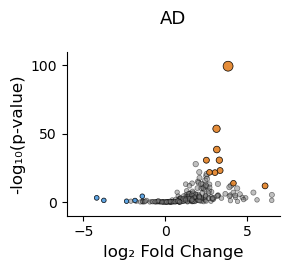

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from adjustText import adjust_text

# Read the dataset
file_path = '../../data/4.AD/AR+ST+ET+event+Prot+Met+Pop.csv'
data = pd.read_csv(file_path)

# Assuming protein data starts
protein_data = data.iloc[:, 3:289]
labels = data['event']

# Read the mapping table for protein and metabolite data
prot_met_mapping = pd.read_csv('../../data/Prot_Met-coding.csv')
protein_names = pd.read_csv('../../data/olink_data_coding143.csv')

# Rename columns in the mapping and protein names dataframes for consistency
prot_met_mapping = prot_met_mapping.rename(columns={prot_met_mapping.columns[0]: 'Prot_Met', prot_met_mapping.columns[1]: 'coding'})
protein_names = protein_names.rename(columns={protein_names.columns[0]: 'coding', protein_names.columns[1]: 'Protein_Name'})

# Merge protein mapping and names based on the 'coding' column
mapping = pd.merge(prot_met_mapping, protein_names, on='coding', how='inner')
mapping_dict = dict(zip(mapping['Prot_Met'], mapping['Protein_Name']))

# Separate healthy and sick groups based on event label
healthy_data = protein_data[labels == 0]
sick_data = protein_data[labels == 1]

# Calculate log fold change (logFC) and p-values for each protein
logFC = np.log2(sick_data.mean() / healthy_data.mean())
p_values = np.array([ttest_ind(healthy_data[col], sick_data[col])[1] for col in protein_data.columns])

# Create a DataFrame to store the volcano plot data
volcano_data = pd.DataFrame({
    'Protein': protein_data.columns,
    'logFC': logFC,
    'p_value': p_values
})

# Add protein names to the volcano plot data
volcano_data['Protein_Name'] = volcano_data['Protein'].map(mapping_dict)

# Calculate -log10(p-value) for the plot
volcano_data['neg_log10_p'] = -np.log10(volcano_data['p_value'])

# Replace infinite and NaN values, and drop them
volcano_data = volcano_data.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate the absolute product of logFC and -log10(p-value) for each protein
volcano_data['abs_product'] = np.abs(volcano_data['logFC']) * np.abs(volcano_data['neg_log10_p'])

# Separate upregulated and downregulated proteins based on logFC values
upregulated = volcano_data[volcano_data['logFC'] > 0]
downregulated = volcano_data[volcano_data['logFC'] < 0]

# Select top 10 upregulated proteins with the highest absolute product
top_10_up = upregulated.nlargest(10, 'abs_product')

# Select top 5 downregulated proteins with the highest absolute product
top_5_down = downregulated.nlargest(5, 'abs_product')

# Output the names of the top upregulated and downregulated proteins
print("Top 10 upregulated proteins (highest abs_product):")
print(top_10_up[['Protein_Name', 'logFC', 'p_value', 'abs_product']])
print("\nTop 5 downregulated proteins (highest abs_product):")
print(top_5_down[['Protein_Name', 'logFC', 'p_value', 'abs_product']])

# Create the volcano plot
fig, ax = plt.subplots(figsize=(3, 2.8))

# Calculate point sizes based on the absolute product (normalized values)
min_size = 10
max_size = 50
size_values = min_size + (max_size-min_size)*(
    (volcano_data['abs_product']-volcano_data['abs_product'].min()) / 
    (volcano_data['abs_product'].max()-volcano_data['abs_product'].min())
)

# Plot all protein points in gray with black borders
plt.scatter(volcano_data['logFC'], 
            volcano_data['neg_log10_p'], 
            color='grey', 
            alpha=0.5, 
            label='Other Proteins',
            s=size_values,
            edgecolor='black',
            linewidths=0.5)

# Mark the top upregulated proteins in orange with black borders
plt.scatter(top_10_up['logFC'], 
            top_10_up['neg_log10_p'], 
            color='#EF8119', 
            alpha=0.8,
            label='Top Upregulated Proteins',
            s=min_size + (max_size-min_size)*(
                (top_10_up['abs_product']-volcano_data['abs_product'].min()) / 
                (volcano_data['abs_product'].max()-volcano_data['abs_product'].min())
            ),
            edgecolor='black',
            linewidths=0.5)

# Mark the top downregulated proteins in blue with black borders
plt.scatter(top_5_down['logFC'], 
            top_5_down['neg_log10_p'], 
            color='#489FEC', 
            alpha=0.8,
            label='Top Downregulated Proteins',
            s=min_size + (max_size-min_size)*(
                (top_5_down['abs_product']-volcano_data['abs_product'].min()) / 
                (volcano_data['abs_product'].max()-volcano_data['abs_product'].min())
            ),
            edgecolor='black',
            linewidths=0.5)

# Set x-ticks and x-axis
plt.xticks(np.arange(-5, max(volcano_data['logFC']) + 1, 5))
ax.set_xlim([-6, 7])

# Set y-ticks and y-axis
plt.yticks(np.arange(0, max(volcano_data['neg_log10_p']) + 1, 50))
ax.set_ylim([-10, 110])

# Adjust tick label sizes for both axes
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

# Add axis labels
plt.xlabel('log₂ Fold Change', fontsize=12)
plt.ylabel('-log₁₀(p-value)', fontsize=12)

# Modify title font and padding
plt.title('AD', fontsize=13, pad=20)

# Modify title font and padding
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.tight_layout()
plt.show()